# CS 4650 - Natural Language Understanding - Semester Project
Georgia Tech, Spring 2024 (Instructor: Kartik Goyal)

Group 18

In [378]:
import xml.etree.ElementTree as ET
import numpy as np
import sklearn.metrics as skl
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

import datasets
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

In [83]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

dataset = load_dataset("hyperpartisan_news_detection", 'bypublisher', split="validation")
tokenizer = AutoTokenizer.from_pretrained("alexgshaw/hyperpartisan-classifier", use_fast=True)
pipe = pipeline("text-classification", model="alexgshaw/hyperpartisan-classifier", tokenizer = tokenizer, device=0)

In [204]:
def augmentation(example):
    example["title_text"] = example["title"] + " " + example["text"]
    example["title_lengths"] = len(example["title"])
    example["text_lengths"] = len(example["text"])
    return example

dataset = dataset.map(augmentation)

Map: 100%|██████████| 150000/150000 [00:15<00:00, 9787.72 examples/s] 


In [90]:
preds = []

for out in tqdm(pipe(KeyDataset(dataset, "title_text"), truncation=True, padding=True, return_all_scores=True)):
    preds.append(out)

c:\Users\pengu\.conda\envs\cs4650_project\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 150000/150000 [24:55<00:00, 100.27it/s]

[{'label': 'NEUTRAL', 'score': 3.1055080853548134e-06}, {'label': 'HYPERPARTISAN', 'score': 0.9999969005584717}]


In [438]:
ground_truths = np.array([0 if data == False else 1 for data in dataset["hyperpartisan"]])
predictions = []
scores = []
for i in range(len(preds)):
    if preds[i][0]["score"] > preds[i][1]["score"]:
        predictions.append(0)
        scores.append(preds[i][0]["score"])
    else:
        predictions.append(1)
        scores.append(preds[i][1]["score"])
predictions = np.array(predictions)
scores = np.array(scores)

tp = np.sum(np.logical_and(ground_truths == 1, predictions == 1))
tn = np.sum(np.logical_and(ground_truths == 0, predictions == 0))
fp = np.sum(np.logical_and(ground_truths == 0, predictions == 1))
fn = np.sum(np.logical_and(ground_truths == 1, predictions == 0))

total = tp + tn + fp + fn
accuracy = (tp + tn) / total
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
fpr = fp / (fp + tn)

print("Accuracy: ", round(accuracy, 2))
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1 Score: ", round(f1, 2))
print("FPR: ", fpr)
print(skl.roc_auc_score(ground_truths, scores))
print(scores[np.nonzero(scores * (predictions == ground_truths))].mean())
print(scores[np.nonzero(scores * (predictions != ground_truths))].mean())

Accuracy:  0.58
Precision:  0.55
Recall:  0.83
F1 Score:  0.66
FPR:  0.66536
0.5565872984888889
0.9781325511016723
0.969709517926594


In [408]:
title_lengths = np.array(dataset["title_lengths"])
text_lengths = np.array(dataset["text_lengths"])
tp_idx = np.nonzero(np.logical_and(ground_truths == 1, predictions == 1))
tn_idx = np.nonzero(np.logical_and(ground_truths == 0, predictions == 0))
fp_idx = np.nonzero(np.logical_and(ground_truths == 0, predictions == 1))
fn_idx = np.nonzero(np.logical_and(ground_truths == 1, predictions == 0))
correct = np.nonzero(ground_truths == predictions)
incorrect = np.nonzero(ground_truths != predictions)
bias = np.array(dataset["bias"])

Text(0.5, 1.0, 'True Positive Scores')

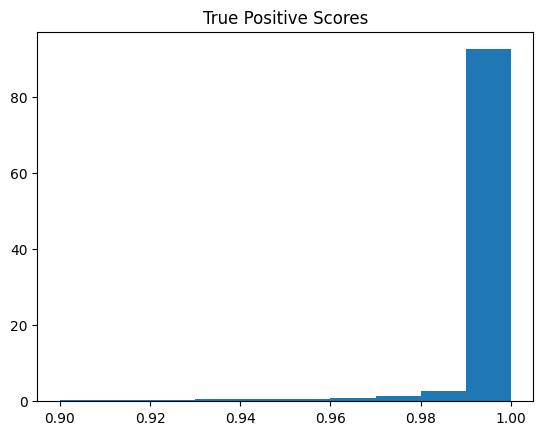

In [404]:
plt.hist(scores[tp_idx], bins=10, range=(0.9,1), density=True)
plt.title("True Positive Scores")

Text(0.5, 1.0, 'True Negative Scores')

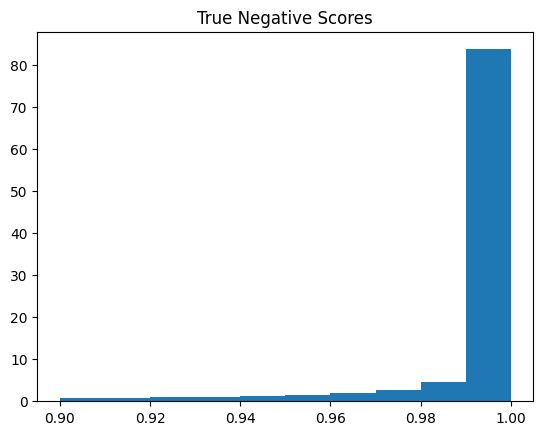

In [402]:
plt.hist(scores[tn_idx], bins=10, range=(0.9,1), density=True)
plt.title("True Negative Scores")

Text(0.5, 1.0, 'False Positive Scores')

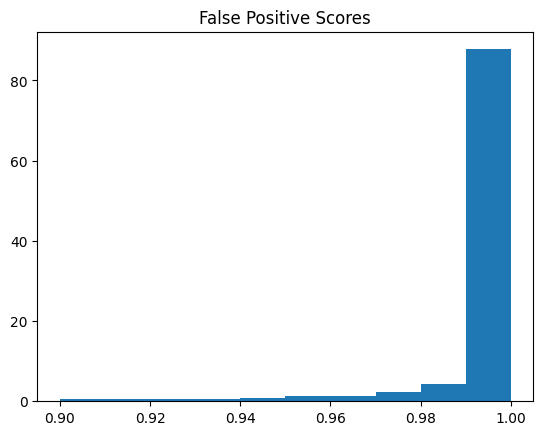

In [403]:
plt.hist(scores[fp_idx], bins=10, range=(0.9,1), density=True)
plt.title("False Positive Scores")

Text(0.5, 1.0, 'False Positive Scores')

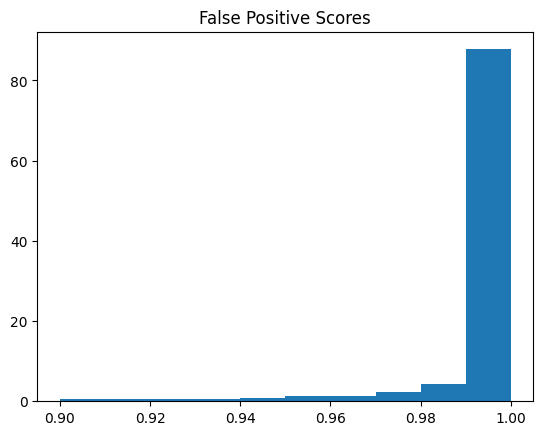

In [405]:
plt.hist(scores[fp_idx], bins=10, range=(0.9,1), density=True)
plt.title("False Positive Scores")

In [334]:
# Plots density histogram correctly, as density arg doesn't work intuitively in matplotlib
def plot_histogram(x, bins, largest_size, title):
    ticks = np.arange(0, bins+1, 2).astype(np.int_)
    labels = (ticks * largest_size / bins).astype(np.int_)
    x = x / largest_size * bins
    plt.hist(x, bins = bins, range = (0, bins), density=True)
    plt.title(title)
    plt.xticks(ticks, labels)

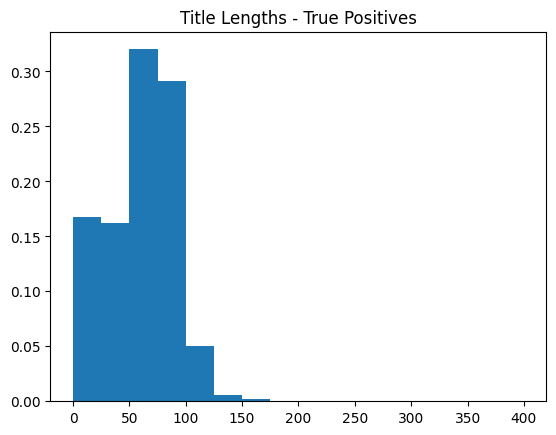

In [335]:
plot_histogram(title_lengths[tp_idx], 16, 400, "Title Lengths - True Positives")


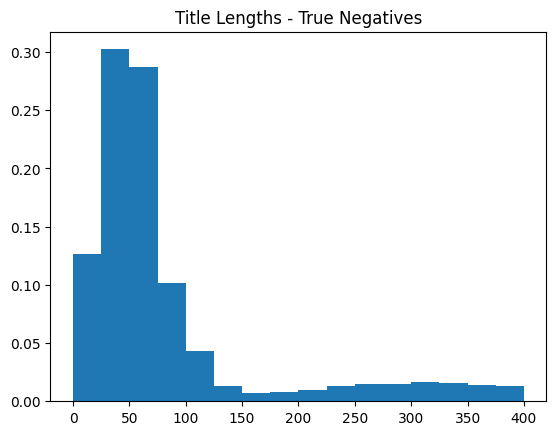

In [336]:
plot_histogram(title_lengths[tn_idx], 16, 400, "Title Lengths - True Negatives")

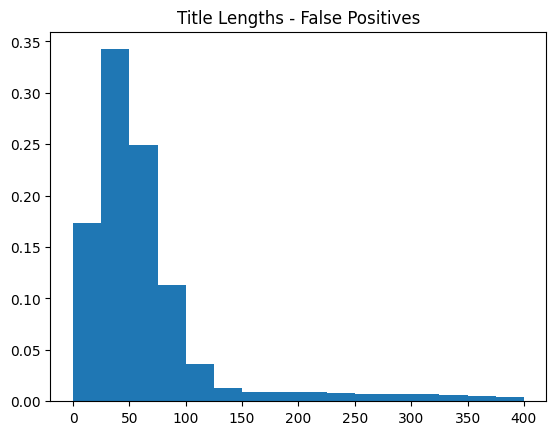

In [337]:
plot_histogram(title_lengths[fp_idx], 16, 400, "Title Lengths - False Positives")

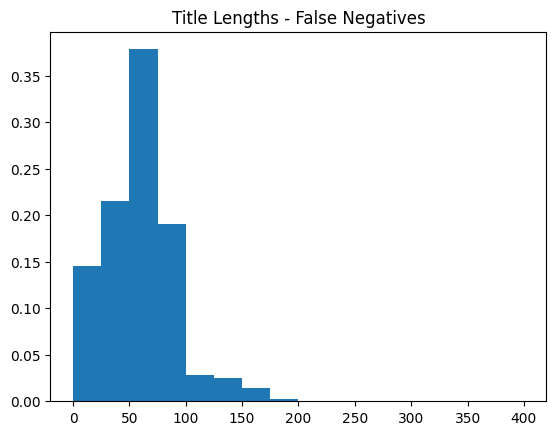

In [338]:
plot_histogram(title_lengths[fn_idx], 16, 400, "Title Lengths - False Negatives")

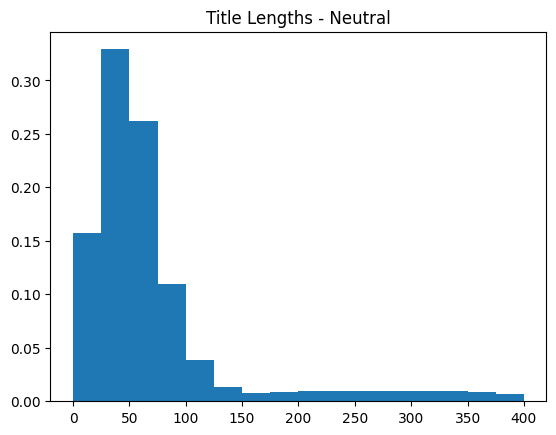

In [339]:
plot_histogram(title_lengths[np.nonzero(ground_truths == 0)], 16, 400, "Title Lengths - Neutral")

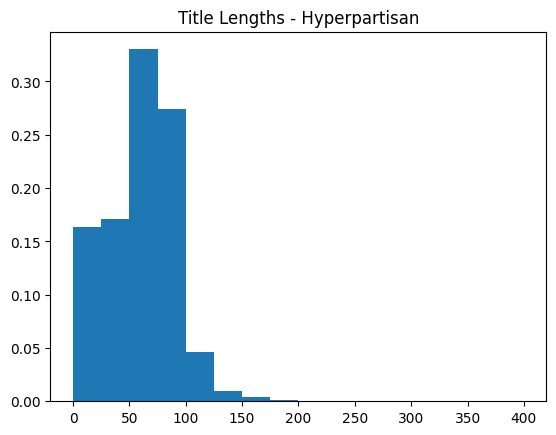

In [340]:
plot_histogram(title_lengths[np.nonzero(ground_truths)], 16, 400, "Title Lengths - Hyperpartisan")

Text(0, 0.5, 'Proportion of All Correct Predictions')

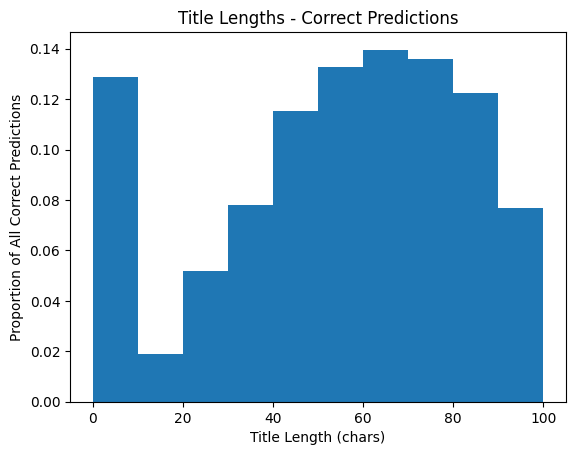

In [435]:
plot_histogram(title_lengths[correct], 10, 100, "Title Lengths - Correct Predictions")
plt.xlabel("Title Length (chars)")
plt.ylabel("Proportion of All Correct Predictions")

Text(0, 0.5, 'Proportion of All Incorrect Predictions')

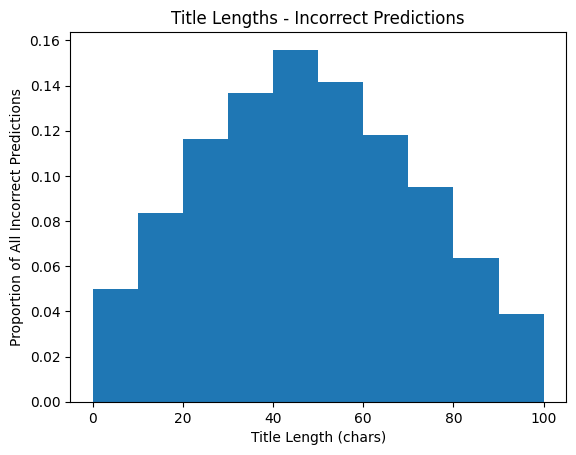

In [434]:
plot_histogram(title_lengths[incorrect], 10, 100, "Title Lengths - Incorrect Predictions")
plt.xlabel("Title Length (chars)")
plt.ylabel("Proportion of All Incorrect Predictions")

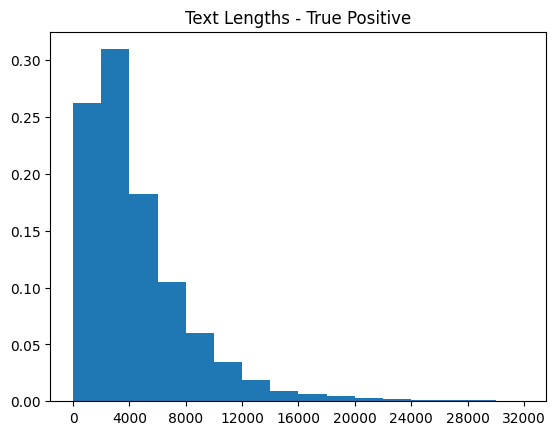

In [341]:
plot_histogram(text_lengths[tp_idx], 16, 32000, "Text Lengths - True Positive")

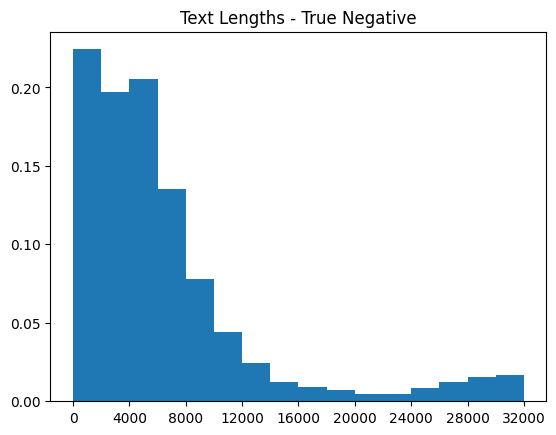

In [342]:
plot_histogram(text_lengths[tn_idx], 16, 32000, "Text Lengths - True Negative")

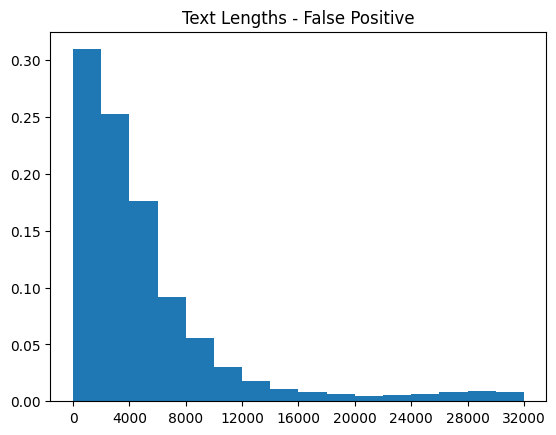

In [343]:
plot_histogram(text_lengths[fp_idx], 16, 32000, "Text Lengths - False Positive")

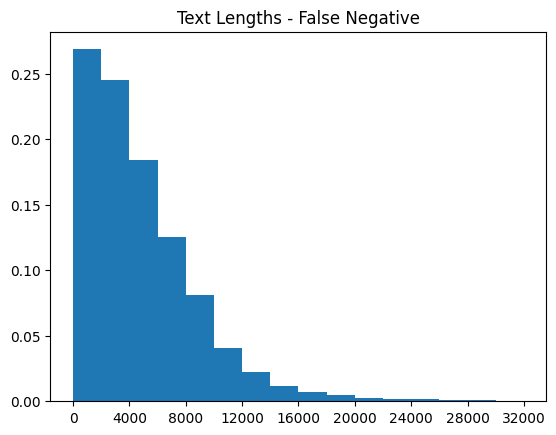

In [344]:
plot_histogram(text_lengths[fn_idx], 16, 32000, "Text Lengths - False Negative")

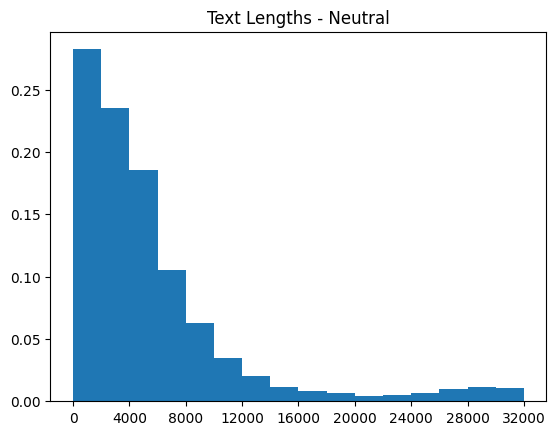

In [345]:
plot_histogram(text_lengths[np.nonzero(ground_truths == 0)], 16, 32000, "Text Lengths - Neutral")

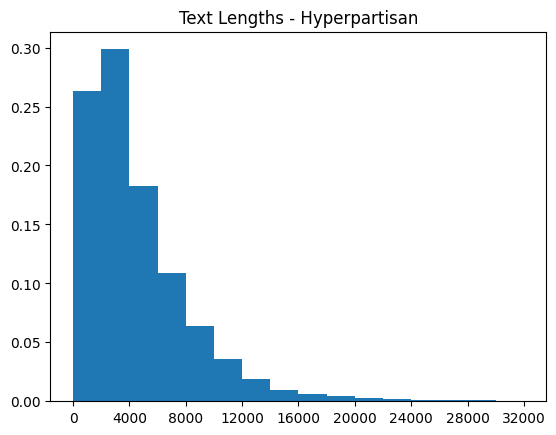

In [346]:
plot_histogram(text_lengths[np.nonzero(ground_truths)], 16, 32000, "Text Lengths - Hyperpartisan")

Text(0, 0.5, 'Proportion of All Correct Predictions')

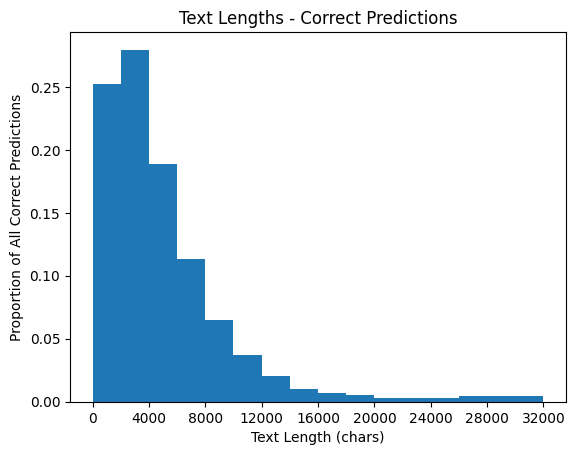

In [432]:
plot_histogram(text_lengths[correct], 16, 32000, "Text Lengths - Correct Predictions")
plt.xlabel("Text Length (chars)")
plt.ylabel("Proportion of All Correct Predictions")

Text(0, 0.5, 'Proportion of All Incorrect Predictions')

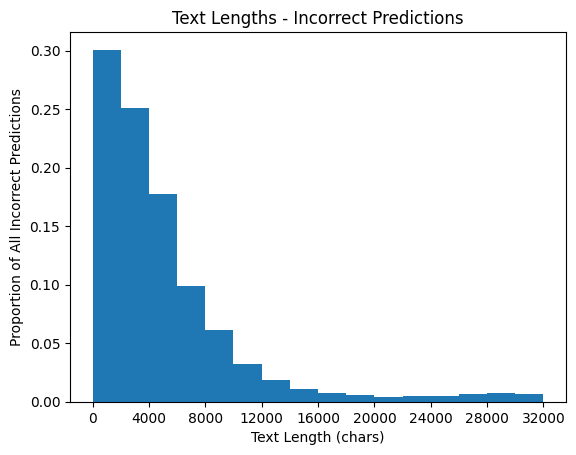

In [436]:
plot_histogram(text_lengths[incorrect], 16, 32000, "Text Lengths - Incorrect Predictions")
plt.xlabel("Text Length (chars)")
plt.ylabel("Proportion of All Incorrect Predictions")

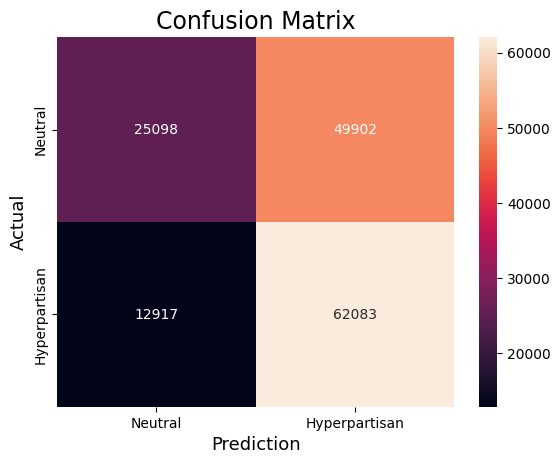

In [398]:
cm = confusion_matrix(ground_truths, predictions)  
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['Neutral','Hyperpartisan'],
            yticklabels=['Neutral','Hyperpartisan'])
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

<BarContainer object of 5 artists>

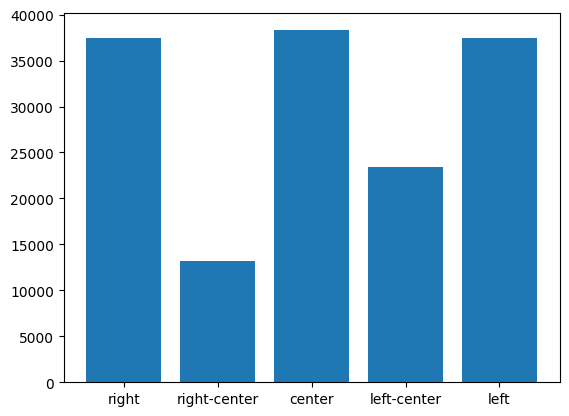

In [411]:
bars = ["right", "right-center", "center", "left-center", "left"]
heights = []
for i in range(5):
    heights.append(np.sum(bias == i))

plt.bar(bars, heights)

Text(0, 0.5, 'Percent of Correct Predictions')

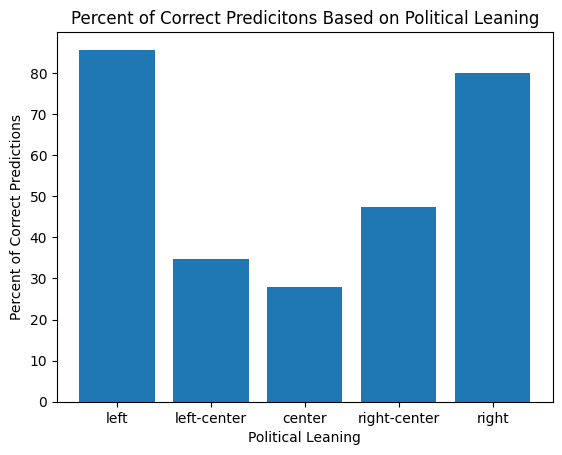

In [431]:
bars = ["left", "left-center", "center", "right-center", "right"]
heights = []
for i in range(4, -1, -1):
    heights.append(np.sum(np.logical_and(bias == i, ground_truths == predictions)) / np.sum(bias == i) * 100)

plt.bar(bars, heights)
plt.title("Percent of Correct Predicitons Based on Political Leaning")
plt.xlabel("Political Leaning")
plt.ylabel("Percent of Correct Predictions")

<BarContainer object of 5 artists>

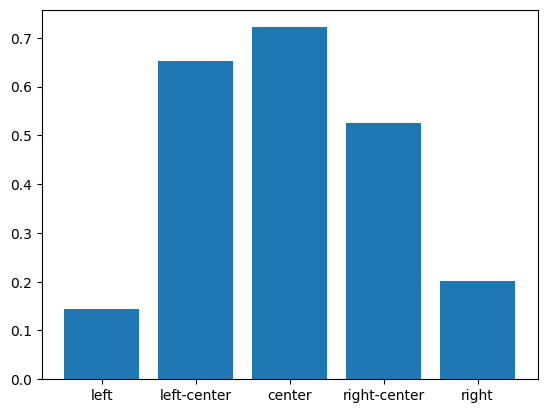

In [418]:
bars = ["left", "left-center", "center", "right-center", "right"]
heights = []
for i in range(4, -1, -1):
    heights.append(np.sum(np.logical_and(bias == i, ground_truths != predictions)) / np.sum(bias == i))

plt.bar(bars, heights)

Text(0, 0.5, 'Portion of Dataset')

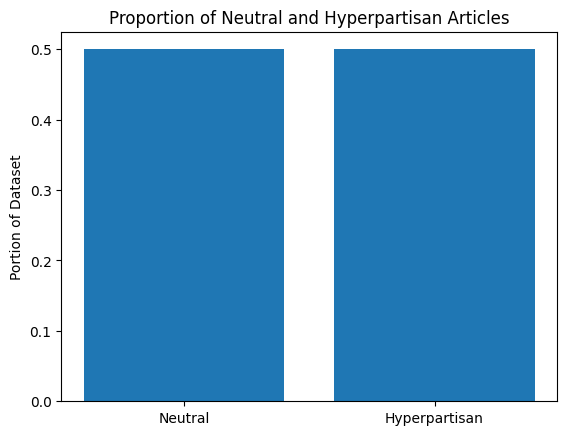

In [429]:
heights = [np.sum(ground_truths == 0) / ground_truths.size, np.sum(ground_truths) / ground_truths.size]
bars = ["Neutral", "Hyperpartisan"]

plt.bar(bars, heights)
plt.title("Proportion of Neutral and Hyperpartisan Articles")
plt.ylabel("Portion of Dataset")

In [446]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_dataset = load_dataset("hyperpartisan_news_detection", 'bypublisher', split="train[:10000]")
tokenizer = AutoTokenizer.from_pretrained("anasrz/finetuning-hyperpartisan-model-samples")
pipe = pipeline("text-classification", model="anasrz/finetuning-hyperpartisan-model-samples", tokenizer = tokenizer, device=0)

def augmentation(example):
    example["title_text"] = example["title"] + " " + example["text"]
    example["title_lengths"] = len(example["title"])
    example["text_lengths"] = len(example["text"])
    return example

train_dataset = train_dataset.map(augmentation)

c:\Users\pengu\.conda\envs\cs4650_project\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pengu\.cache\huggingface\hub\models--anasrz--finetuning-hyperpartisan-model-samples. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [447]:
train = []

for out in tqdm(pipe(KeyDataset(train_dataset, "title_text"), truncation=True, padding=True, return_all_scores=True)):
    train.append(out)

c:\Users\pengu\.conda\envs\cs4650_project\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 10000/10000 [01:35<00:00, 104.20it/s]


In [448]:
ground_truths = np.array([0 if data == False else 1 for data in train_dataset["hyperpartisan"]])
predictions = []
scores = []
for i in range(len(train)):
    if train[i][0]["score"] > train[i][1]["score"]:
        predictions.append(0)
        scores.append(train[i][0]["score"])
    else:
        predictions.append(1)
        scores.append(train[i][1]["score"])
predictions = np.array(predictions)
scores = np.array(scores)

tp = np.sum(np.logical_and(ground_truths == 1, predictions == 1))
tn = np.sum(np.logical_and(ground_truths == 0, predictions == 0))
fp = np.sum(np.logical_and(ground_truths == 0, predictions == 1))
fn = np.sum(np.logical_and(ground_truths == 1, predictions == 0))

total = tp + tn + fp + fn
accuracy = (tp + tn) / total
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
fpr = fp / (fp + tn)

print("Accuracy: ", round(accuracy, 2))
print("Precision: ", round(precision, 2))
print("Recall: ", round(recall, 2))
print("F1 Score: ", round(f1, 2))
print("FPR: ", fpr)
print(skl.roc_auc_score(ground_truths, scores))
print(scores[np.nonzero(scores * (predictions == ground_truths))].mean())
print(scores[np.nonzero(scores * (predictions != ground_truths))].mean())

Accuracy:  0.45
Precision:  0.45
Recall:  0.4
F1 Score:  0.42
FPR:  0.5067690442513639
0.5496633669767003
0.7265741703434341
0.7680569525575517
